<a href="https://colab.research.google.com/github/AmrIdlibi-dotcom/mars-rover-navigation-rl/blob/main/Mars_Rover_Navigation_Simulation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 0 | Total reward: -100.0 | Eps: 0.995
Episode 200 | Total reward: -168.0 | Eps: 0.365
Episode 400 | Total reward: -162.0 | Eps: 0.134
Episode 600 | Total reward: 81.0 | Eps: 0.050
Episode 800 | Total reward: 81.0 | Eps: 0.050
Episode 1000 | Total reward: 83.0 | Eps: 0.050
Episode 1200 | Total reward: 83.0 | Eps: 0.050
Episode 1400 | Total reward: 83.0 | Eps: 0.050
Episode 1600 | Total reward: 83.0 | Eps: 0.050
Episode 1800 | Total reward: 83.0 | Eps: 0.050


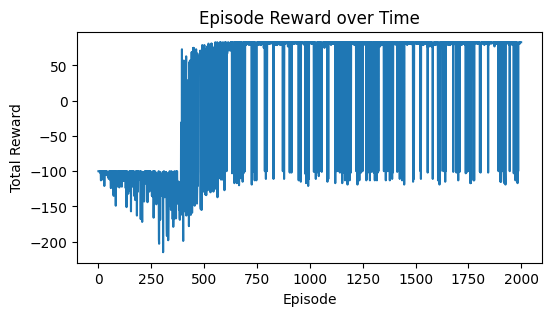

Showing episode 1999 with reward 83.0


In [ ]:
# ============================================================
# 🪐 Mars Rover Navigation with Q-learning + Live Animation
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from IPython.display import HTML

# --------------------------
# 1️⃣ Environment Parameters
# --------------------------
GRID_SIZE = 10
NUM_EPISODES = 2000
MAX_STEPS = 200
OBSTACLE_DENSITY = 0.15   # 15% of cells become obstacles
ALPHA = 0.1               # learning rate
GAMMA = 0.9               # discount factor
EPSILON = 1.0             # exploration rate
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.05

# --------------------------
# 2️⃣ Create Mars Terrain
# --------------------------
def create_environment():
    env = np.zeros((GRID_SIZE, GRID_SIZE))
    num_obstacles = int(OBSTACLE_DENSITY * GRID_SIZE * GRID_SIZE)
    for _ in range(num_obstacles):
        y, x = np.random.randint(0, GRID_SIZE, 2)
        env[y, x] = -1  # obstacle
    start = (0, 0)
    goal = (GRID_SIZE - 1, GRID_SIZE - 1)
    env[start] = 0
    env[goal] = 2
    return env, start, goal

env, start_state, goal_state = create_environment()

# Actions: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
Q = np.zeros((GRID_SIZE, GRID_SIZE, len(actions)))

# --------------------------
# 3️⃣ Helper Functions
# --------------------------
def is_valid(state):
    y, x = state
    if 0 <= y < GRID_SIZE and 0 <= x < GRID_SIZE:
        return env[y, x] != -1
    return False

def step(state, action_index):
    dy, dx = actions[action_index]
    y, x = state
    next_state = (y + dy, x + dx)
    if not is_valid(next_state):
        reward = -100
        done = True
        return state, reward, done
    if next_state == goal_state:
        reward = 100
        done = True
        return next_state, reward, done
    reward = -1  # step penalty
    done = False
    return next_state, reward, done

# --------------------------
# 4️⃣ Training Loop
# --------------------------
rewards_per_episode = []
paths = []  # store some paths for animation

for ep in range(NUM_EPISODES):
    state = start_state
    total_reward = 0
    path = [state]

    for step_i in range(MAX_STEPS):
        # choose action
        if random.uniform(0, 1) < EPSILON:
            action_index = np.random.randint(0, len(actions))
        else:
            action_index = np.argmax(Q[state[0], state[1]])

        next_state, reward, done = step(state, action_index)

        # Q-learning update
        best_next = np.max(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], action_index] += ALPHA * (reward + GAMMA * best_next - Q[state[0], state[1], action_index])

        state = next_state
        total_reward += reward
        path.append(state)

        if done:
            break

    rewards_per_episode.append(total_reward)
    paths.append(path)

    # decay epsilon
    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

    # print occasional update
    if ep % 200 == 0:
        print(f"Episode {ep} | Total reward: {total_reward:.1f} | Eps: {EPSILON:.3f}")

# --------------------------
# 5️⃣ Visualize Learning Curve
# --------------------------
plt.figure(figsize=(6,3))
plt.plot(rewards_per_episode)
plt.title("Episode Reward over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# --------------------------
# 6️⃣ Live Animation Function
# --------------------------
# --- STEP 6: Pick a good episode to visualize ---
def pick_episode(rewards, paths):
    rewards = np.array(rewards)
    good_idxs = np.where(rewards > 0)[0]
    if len(good_idxs):
        idx = int(good_idxs[-1])       # last success
    else:
        idx = int(np.argmax(rewards))  # best overall
    return idx, paths[idx], rewards[idx]

best_index, best_path, best_reward = pick_episode(rewards_per_episode, paths)
print(f"Showing episode {best_index} with reward {best_reward:.1f}")


# --- STEP 7: Animation function (fixed) ---
def animate_path(path, env, goal_state):
    fig, ax = plt.subplots(figsize=(5,5))

    # visualize obstacles + goal
    grid_display = np.zeros_like(env, dtype=float)
    grid_display[env == -1] = 0.3   # gray obstacles
    grid_display[env == 2]  = 0.7   # goal
    ax.imshow(grid_display, cmap='gray_r', origin='upper')

    # rover (red) and goal (green)
    rover_dot, = ax.plot([], [], 'ro', markersize=10)
    gy, gx = goal_state
    ax.plot([gx], [gy], 'go', markersize=10)

    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Mars Rover Simulation (Episode Playback)")

    def init():
        rover_dot.set_data([], [])
        return (rover_dot,)

    def update(frame):
        y, x = path[frame]
        rover_dot.set_data([x], [y])   # pass sequences
        return (rover_dot,)

    ani = animation.FuncAnimation(
        fig, update, frames=len(path),
        init_func=init, blit=True, interval=120
    )
    plt.close(fig)
    return HTML(ani.to_jshtml())

# --- STEP 8: Run the animation (TOP-LEVEL, no indentation) ---
animate_path(best_path, env, goal_state)


